In [1]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import mayavi
import mayavi.mlab
import string
import subprocess
import functools
import cv2
import itertools
from local_models.quadric_models import *
from local_models.plotting_utils import *
from joblib import Parallel, delayed


#on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
mayavi.mlab.options.offscreen = True



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [3]:
project_dir = "../data/simple_quadrics"
os.makedirs(project_dir, exist_ok=1)

In [4]:
import local_models.quadrics_utils_2

projection_funcs = {
    "k_mat": local_models.quadrics_utils_2.k_mat_2,
    "other_dims_as_x": local_models.quadrics_utils_2.other_dims_as_x_2,
}

In [5]:
def tf_parabolic_project_2d(x, q, imag_0tol=1e-10):
    with tf.Graph().as_default(), tf.Session() as sess:
        test_qs = tf.placeholder(tf.float32, q.shape)
        test_pts = tf.placeholder(tf.float32, x.shape)
        test_qsc = tf.cast(q_test, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
        test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
        sol_tf = local_models.tf_quadric_models.tf_parabolic_project(test_qsc, test_ptsc, imag_0tol=imag_0tol, regular_projection_funcs = parabolic_proj_funcs2d[0], special_projection_funcs=parabolic_proj_funcs2d[0])
        res = sess.run(sol_tf, feed_dict={test_pts: x, test_qs: q})
    return res

In [6]:
q = np.array([ # an ellipse
    [0.5,0,0],
    [0,0.25,-1],
    [0,-1,0.1],
])
u = np.arange(4).reshape(2,2)
u += u.T
l, u = np.linalg.eig(u)

test_x = np.arange(12).reshape(6,2)*1.

E = np.block([[u, test_x[0].reshape(-1,1)],[np.zeros(2), 1]])
Einv = np.linalg.inv(E)
q_test = Einv.T@q@Einv
intermediate_results = local_models.quadric_models.orthogonal_quadric_project_x(test_x,q_test,projection_funcs)
proj_x, _ = local_models.quadric_models.min_dist_search(*intermediate_results, projection_funcs)

[0.25 0.5 ] [[-0.38268343 -0.92387953]
 [-0.92387953  0.38268343]]


In [7]:
x = np.mgrid[-6:4:13j,-6:4:13j]
big_x = np.mgrid[-7:3:80j,-7:3:80j]
big_x = big_x.reshape(big_x.shape[0],-1)
big_x = big_x.T
x = x.reshape(x.shape[0],-1)
x = x.T

In [8]:
x.shape

(169, 2)

In [9]:
projected, dists = local_models.quadric_models.orthogonal_quadric_projection(x,q_test,projection_funcs)
projected_bigx, dists_bigx = local_models.quadric_models.orthogonal_quadric_projection(big_x,q_test,projection_funcs)

[0.25 0.5 ] [[-0.38268343 -0.92387953]
 [-0.92387953  0.38268343]]
[0.25 0.5 ] [[-0.38268343 -0.92387953]
 [-0.92387953  0.38268343]]


In [10]:
projected.shape

(169, 2)

(-6.50739247311828, 4.50739247311828, -7.031912150581063, 4.532556102618861)

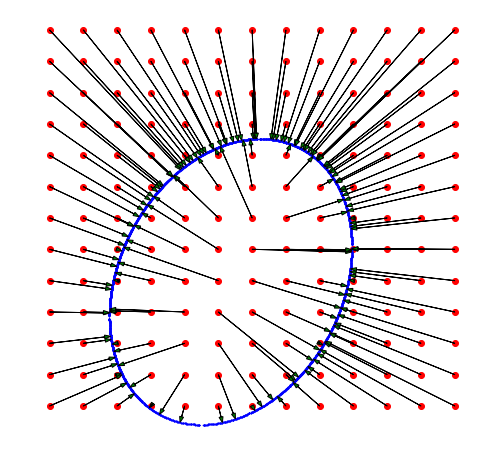

In [11]:
plt.scatter(x[:,0],x[:,1],c='r')
for i in range(x.shape[0]):
    plt.arrow(*np.concatenate((x[i],projected[i]-x[i])),head_width=0.1,fc='g',length_includes_head=True)
plt.scatter(projected_bigx[:,0],projected_bigx[:,1],c='b',s=0.5)
plt.axis('off')

In [12]:
E

array([[-0.92387953, -0.38268343,  0.        ],
       [ 0.38268343, -0.92387953,  1.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [13]:
ellipse_dir = os.path.join(project_dir, "rotating_ellipse")
os.makedirs(ellipse_dir, exist_ok=1)

big_x = np.mgrid[-10:20:80j,-10:20:80j]
big_x = big_x.reshape(big_x.shape[0],-1)
big_x = big_x.T

E_x2 = np.block([[u, test_x[1].reshape(-1,1)],[np.zeros(2), 1]])
for i,alpha in enumerate(np.linspace(0,1,20,endpoint=True)):
    E_alpha = (1-alpha)*np.eye(3) + alpha*E_x2
    E_alpha[:2,:2] = E_alpha[:2,:2] / np.linalg.norm(E_alpha[:2,0])
    
    halfrot_q = E_alpha.T@q_test@E_alpha
    projected_bigx, dists_bigx = local_models.quadric_models.orthogonal_quadric_projection(big_x,halfrot_q,projection_funcs)
    plt.scatter(projected_bigx[:,0],projected_bigx[:,1],c='b',s=0.5)
    plt.scatter(*((np.concatenate((test_x[1],[1]))@np.linalg.inv(E_alpha).T)[:2]),c='r')
    plt.xlim(-10,7)
    plt.ylim(-8,9)
    plt.savefig(os.path.join(ellipse_dir, "{}.png".format(i)))
    plt.clf()

[0.25 0.5 ] [[-0.38268343 -0.92387953]
 [-0.92387953  0.38268343]]
[0.25 0.5 ] [[-0.40328672 -0.91507367]
 [-0.91507367  0.40328672]]
[0.25 0.5 ] [[-0.42880356 -0.90339776]
 [-0.90339776  0.42880356]]
[0.25 0.5 ] [[-0.46113084 -0.88733215]
 [-0.88733215  0.46113084]]
[0.25 0.5 ] [[-0.50319321 -0.86417394]
 [-0.86417394  0.50319321]]
[0.25 0.5 ] [[-0.55960965 -0.82875632]
 [-0.82875632  0.55960965]]
[0.25 0.5 ] [[-0.63762343 -0.77034821]
 [-0.77034821  0.63762343]]
[0.25 0.5 ] [[-0.74703781 -0.66478155]
 [-0.66478155  0.74703781]]
[0.25 0.5 ] [[-0.88947851 -0.456977  ]
 [-0.456977    0.88947851]]
[0.25 0.5 ] [[-0.99805877 -0.06227909]
 [-0.06227909  0.99805877]]
[0.25 0.5 ] [[-0.8982529   0.43947894]
 [ 0.43947894  0.8982529 ]]
[0.25 0.5 ] [[ 0.64689346 -0.76258039]
 [-0.76258039 -0.64689346]]
[0.25 0.5 ] [[ 0.43577205 -0.90005706]
 [-0.90005706 -0.43577205]]
[0.25 0.5 ] [[ 0.29428774 -0.95571687]
 [-0.95571687 -0.29428774]]
[0.25 0.5 ] [[ 0.19986059 -0.97982434]
 [-0.97982434 -0.199860

In [14]:
test_x[1:2]

array([[2., 3.]])

[0.25 0.5 ] [[0. 1.]
 [1. 0.]]
[2.71556505 0.63016482]
[[ 3.34572987  0.63016482 -2.08540023]
 [ 2.08540023  2.71556505  3.34572987]]


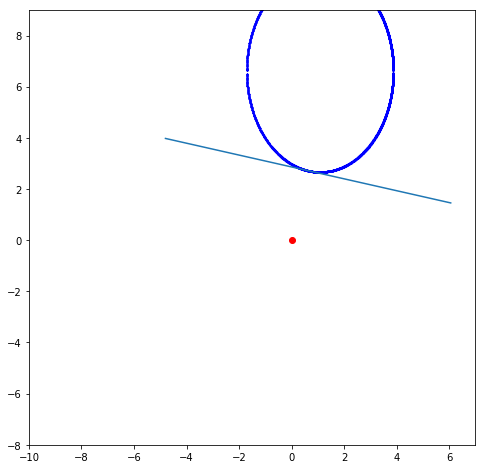

In [15]:
rotx = (np.concatenate((test_x[1],[1]))@np.linalg.inv(E_alpha).T)[:2].reshape(1,-1)
projected_testx, _ = local_models.quadric_models.orthogonal_quadric_projection(rotx,halfrot_q,projection_funcs)
plt.scatter(projected_bigx[:,0],projected_bigx[:,1],c='b',s=0.5)
plt.scatter(*(rotx.T),c='r')
plt.xlim(-10,7)
plt.ylim(-8,9)
tangent_vec = (projected_testx - rotx)[0,::-1]
print(tangent_vec)
tangent_vec[1] *= -1
print(np.concatenate((projected_testx + tangent_vec, projected_testx, projected_testx - tangent_vec), axis=0).T)
plt.plot(*((np.concatenate((projected_testx + 2*tangent_vec, projected_testx, projected_testx - 2*tangent_vec), axis=0)).T))
plt.savefig(os.path.join(ellipse_dir, "ellipse_w_tangent.png"))

# See what happens near a 0 eig

[-2.   0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.9  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.8  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.7  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.6  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.5  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.4  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.3  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.2  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.1  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-1.   0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-0.9  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-0.8  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-0.7  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]
[-0.6  0.5] [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.382683

(-10.374652240090025, 8.587076535767059, -9.33699570650508, 11.880601289588874)

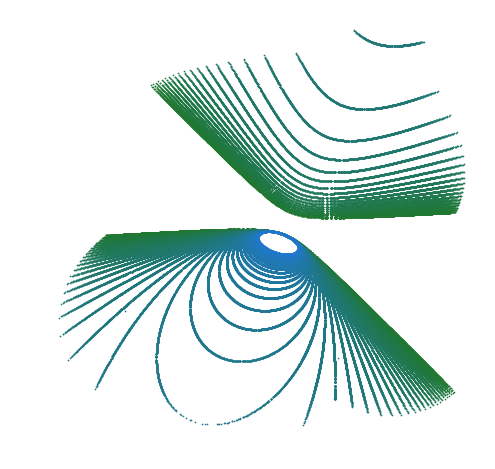

In [16]:
various_qs = []
for i in range(-20,20):
    q = np.array([ # an ellipse
        [0.5,0,0],
        [0,i/10,-1],
        [0,-1,0.1],
    ])
    u = np.arange(4).reshape(2,2)
    u += u.T
    l, u = np.linalg.eig(u)

    x = np.arange(12).reshape(6,2)*1.

    E = np.block([[u, x[0].reshape(-1,1)],[np.zeros(2), 1]])
    Einv = np.linalg.inv(E)
    q_test = Einv.T@q@Einv
    
    big_x = np.mgrid[-7:7:80j,-7:7:80j]
    big_x = big_x.reshape(big_x.shape[0],-1)
    big_x = big_x.T
    
    try:
        projected_bigx, dists_bigx = local_models.quadric_models.orthogonal_quadric_projection(big_x,q_test,projection_funcs)
    except:
        print(i)
    c = 0x1f7780
    plt.scatter(projected_bigx[:,0],projected_bigx[:,1],c="#" + hex(c+4*i)[2:],s=0.5)
plt.axis('off')

In [17]:
import local_models.tf_quadric_models
import tensorflow as tf

In [18]:
parabolic_proj_funcs2d = local_models.tf_quadric_models.arrange_parabolic_projection_funcs(2)

In [19]:
parabolic_proj_funcs2d

({'k_mat': <function parabolic_utils_2.k_mat0_2(q_1_1, q_2_2, q_2_0, q_2_1)>,
  'other_dims_as_x': functools.partial(<function munge_other_dims at 0x7f86f9187b70>, 2, 0, other_dims_func=<function other_dims_as_x0_2 at 0x7f86f918cae8>)},
 {'k_mat': <function parabolic_utils_2.k_mat1_2(q_1_1, q_2_2, q_2_0, q_2_1)>,
  'other_dims_as_x': functools.partial(<function munge_other_dims at 0x7f86f9187b70>, 2, 1, other_dims_func=<function other_dims_as_x1_2 at 0x7f86f918cb70>)})

In [20]:
q2d = np.array([[0,0,2],[0,1,4],[2,4,3]])

In [21]:
q2d

array([[0, 0, 2],
       [0, 1, 4],
       [2, 4, 3]])

In [22]:
rot = np.array([[np.cos(1), -np.sin(1)],[np.sin(1), np.cos(1)]])

In [23]:
shift = np.array([[1,2]])

In [24]:
E = np.block([[rot, shift.T],[np.zeros(2), 1]])
Einv = np.linalg.inv(E)
q_test = q2d#E.T@q2d@E

In [25]:
xy_grid = np.mgrid[-10:20:100j,-10:20:100j]
xy = xy_grid.T.reshape(-1,2)

In [26]:
xy_grid.shape, xy_grid.T.shape

((2, 100, 100), (100, 100, 2))

In [27]:
small_xy_grid = xy_grid[:,::10,::10]
small_xy = small_xy_grid.T.reshape(-1,2)

In [28]:
small_xy.shape

(100, 2)

In [29]:
xy.shape

(10000, 2)

In [30]:
xy[::10].shape

(1000, 2)

In [31]:
small_xy

array([[-10.        , -10.        ],
       [ -6.96969697, -10.        ],
       [ -3.93939394, -10.        ],
       [ -0.90909091, -10.        ],
       [  2.12121212, -10.        ],
       [  5.15151515, -10.        ],
       [  8.18181818, -10.        ],
       [ 11.21212121, -10.        ],
       [ 14.24242424, -10.        ],
       [ 17.27272727, -10.        ],
       [-10.        ,  -6.96969697],
       [ -6.96969697,  -6.96969697],
       [ -3.93939394,  -6.96969697],
       [ -0.90909091,  -6.96969697],
       [  2.12121212,  -6.96969697],
       [  5.15151515,  -6.96969697],
       [  8.18181818,  -6.96969697],
       [ 11.21212121,  -6.96969697],
       [ 14.24242424,  -6.96969697],
       [ 17.27272727,  -6.96969697],
       [-10.        ,  -3.93939394],
       [ -6.96969697,  -3.93939394],
       [ -3.93939394,  -3.93939394],
       [ -0.90909091,  -3.93939394],
       [  2.12121212,  -3.93939394],
       [  5.15151515,  -3.93939394],
       [  8.18181818,  -3.93939394],
 

In [32]:
xy[::10]

array([[-10.        , -10.        ],
       [ -6.96969697, -10.        ],
       [ -3.93939394, -10.        ],
       ...,
       [ 11.21212121,  20.        ],
       [ 14.24242424,  20.        ],
       [ 17.27272727,  20.        ]])

In [33]:
imag_tol_powers = np.linspace(-20,20,41)
imag_tols = 2**imag_tol_powers
results = []
for imag_tol in imag_tols:
    results.append(
        tf_parabolic_project_2d(xy, q_test, imag_0tol=imag_tol)
    )

Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("add:0", shape=(10000, 2), dtype=complex64) Tensor("add_2:0", shape=(10000, 1), dtype=complex64)
args0 Tensor("cond/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond/mul_9:0", shape=(?, 

mask Tensor("cond_1/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond_1/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond_1/mul_13:0", shape=(?, ?), dtype=complex64)
select_result Tensor("cond_1/add_2:0", shape=(?, ?), dtype=complex64)
(?, ?)
munging_dims (1, ?, ?) (1, ?, ?)
munged (2, ?, ?)
pts Tensor("cond_1/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond_1/Greater_1:0", shape=(?, ?), dtype=bool)
dists Tensor("cond_1/Sum_1:0", shape=(?, ?), dtype=float32)
special_pts Tensor("cond_1/Merge:0", shape=(?, 2), dtype=complex64)
Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("Gat

regular_pts Tensor("cond/Merge:0", shape=(?, 2), dtype=complex64)
args0 Tensor("cond_1/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond_1/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond_1/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond_1/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond_1/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond_1/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond_1/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond_1/mul_9:0", shape=(?, 1), dtype=complex64)
(?, 1)
kmat Tensor("cond_1/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond_1/strided_slice_6:0", shape=(?, 4), dtype=complex64)
zero_indices Tensor("cond_1/ArgMax:0", shape=(?,), dtype=int64)
mask Tensor("cond_1/Less:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_2:0", shape=(), dtype=complex64)

coeffses0 Tensor("cond/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond/mul_9:0", shape=(?, 1), dtype=complex64)
(?, 1)
kmat Tensor("cond/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond/strided_slice_6:0", shape=(?, 4), dtype=complex64)
zero_indices Tensor("cond/ArgMax:0", shape=(?,), dtype=int64)
mask Tensor("cond/Less:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond/Cast_2:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond/strided_slice_6:0", shape=(?, 4), dtype=complex64)
t Tensor("cond/mul_10:0", shape=(?, ?), dtype=complex64)
f Tensor("cond/mul_11:0", shape=(?, 4), dtype=complex64)
select_result Tensor("cond/add:0", shape=(?, 4), dtype=complex64)
zeroed Tensor("cond/add:0", shape=(?, 4), dtype=complex64)
cshape (?, 4)
rotated_coeffs Tensor("cond/Gather/Reshape_3:0", shape=(?, 4), d

sorted_roots Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
mask Tensor("cond_1/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond_1/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond_1/mul_13:0", shape=(?, ?), dtype=complex64)
select_result Tensor("cond_1/add_2:0", shape=(?, ?), dtype=complex64)
(?, ?)
munging_dims (1, ?, ?) (1, ?, ?)
munged (2, ?, ?)
pts Tensor("cond_1/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond_1/Greater_1:0", shape=(?, ?), dtype=bool)
dists Tensor("cond_1/Sum_1:0", shape=(?, ?), dtype=float32)
special_pts Tensor("cond_1/Merge:0", shape=(?, 2), dtype=complex64)
Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), 

regular_pts Tensor("cond/Merge:0", shape=(?, 2), dtype=complex64)
args0 Tensor("cond_1/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond_1/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond_1/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond_1/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond_1/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond_1/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond_1/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond_1/mul_9:0", shape=(?, 1), dtype=complex64)
(?, 1)
kmat Tensor("cond_1/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond_1/strided_slice_6:0", shape=(?, 4), dtype=complex64)
zero_indices Tensor("cond_1/ArgMax:0", shape=(?,), dtype=int64)
mask Tensor("cond_1/Less:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_2:0", shape=(), dtype=complex64)

rotated_coeffs Tensor("cond/Gather/Reshape_3:0", shape=(?, 4), dtype=complex64)
backward_coeffs_to_nless1 Tensor("cond/strided_slice_11:0", shape=(?, 3), dtype=complex64)
unit_lead_coeffs_to_nless1 Tensor("cond/truediv:0", shape=(?, 3), dtype=complex64)
roots Tensor("cond/CompanionEigv:0", shape=(?, ?), dtype=complex64)
sorted_roots Tensor("cond/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
mask Tensor("cond/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond/mul_13:0", shape=(?, ?), dtype=complex64)
select_result Tensor("cond/add_2:0", shape=(?, ?), dtype=complex64)
(?, ?)
munging_dims (1, ?, ?) (1, ?, ?)
munged (2, ?, ?)
pts Tensor("cond/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond/Greater_1:0", shape=(?, ?), dtype=bool)
dists Tensor("cond/Sum_1:0", shap

Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("add:0", shape=(10000, 2), dtype=complex64) Tensor("add_2:0", shape=(10000, 1), dtype=complex64)
args0 Tensor("cond/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond/mul_9:0", shape=(?, 

t Tensor("cond_1/mul_10:0", shape=(?, ?), dtype=complex64)
f Tensor("cond_1/mul_11:0", shape=(?, 4), dtype=complex64)
select_result Tensor("cond_1/add:0", shape=(?, 4), dtype=complex64)
zeroed Tensor("cond_1/add:0", shape=(?, 4), dtype=complex64)
cshape (?, 4)
rotated_coeffs Tensor("cond_1/Gather/Reshape_3:0", shape=(?, 4), dtype=complex64)
backward_coeffs_to_nless1 Tensor("cond_1/strided_slice_11:0", shape=(?, 3), dtype=complex64)
unit_lead_coeffs_to_nless1 Tensor("cond_1/truediv:0", shape=(?, 3), dtype=complex64)
roots Tensor("cond_1/CompanionEigv:0", shape=(?, ?), dtype=complex64)
sorted_roots Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
mask Tensor("cond_1/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond_1/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond_1/mul_13:0", shape=(?, ?), dtype=complex64)
s

regular_pts Tensor("cond/Merge:0", shape=(?, 2), dtype=complex64)
args0 Tensor("cond_1/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond_1/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond_1/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond_1/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond_1/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond_1/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond_1/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond_1/mul_9:0", shape=(?, 1), dtype=complex64)
(?, 1)
kmat Tensor("cond_1/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond_1/strided_slice_6:0", shape=(?, 4), dtype=complex64)
zero_indices Tensor("cond_1/ArgMax:0", shape=(?,), dtype=int64)
mask Tensor("cond_1/Less:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_2:0", shape=(), dtype=complex64)

kmat Tensor("cond/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond/strided_slice_6:0", shape=(?, 4), dtype=complex64)
zero_indices Tensor("cond/ArgMax:0", shape=(?,), dtype=int64)
mask Tensor("cond/Less:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond/Cast_2:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond/strided_slice_6:0", shape=(?, 4), dtype=complex64)
t Tensor("cond/mul_10:0", shape=(?, ?), dtype=complex64)
f Tensor("cond/mul_11:0", shape=(?, 4), dtype=complex64)
select_result Tensor("cond/add:0", shape=(?, 4), dtype=complex64)
zeroed Tensor("cond/add:0", shape=(?, 4), dtype=complex64)
cshape (?, 4)
rotated_coeffs Tensor("cond/Gather/Reshape_3:0", shape=(?, 4), dtype=complex64)
backward_coeffs_to_nless1 Tensor("cond/strided_slice_11:0", shape=(?, 3), dtype=complex64)
unit_lead_coeffs_to_nless1 Tensor("cond/truediv:0", shape=(?, 3), dtype=complex64)
roots Tensor("cond/CompanionEigv:0", shape=(?, ?), dtype=complex64)
sorted_roots Tensor("cond/

mask Tensor("cond_1/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond_1/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond_1/mul_13:0", shape=(?, ?), dtype=complex64)
select_result Tensor("cond_1/add_2:0", shape=(?, ?), dtype=complex64)
(?, ?)
munging_dims (1, ?, ?) (1, ?, ?)
munged (2, ?, ?)
pts Tensor("cond_1/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond_1/Greater_1:0", shape=(?, ?), dtype=bool)
dists Tensor("cond_1/Sum_1:0", shape=(?, ?), dtype=float32)
special_pts Tensor("cond_1/Merge:0", shape=(?, 2), dtype=complex64)
Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("Gat

regular_pts Tensor("cond/Merge:0", shape=(?, 2), dtype=complex64)
args0 Tensor("cond_1/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond_1/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond_1/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond_1/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond_1/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond_1/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond_1/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond_1/mul_9:0", shape=(?, 1), dtype=complex64)
(?, 1)
kmat Tensor("cond_1/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond_1/strided_slice_6:0", shape=(?, 4), dtype=complex64)
zero_indices Tensor("cond_1/ArgMax:0", shape=(?,), dtype=int64)
mask Tensor("cond_1/Less:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_2:0", shape=(), dtype=complex64)

rotated_coeffs Tensor("cond/Gather/Reshape_3:0", shape=(?, 4), dtype=complex64)
backward_coeffs_to_nless1 Tensor("cond/strided_slice_11:0", shape=(?, 3), dtype=complex64)
unit_lead_coeffs_to_nless1 Tensor("cond/truediv:0", shape=(?, 3), dtype=complex64)
roots Tensor("cond/CompanionEigv:0", shape=(?, ?), dtype=complex64)
sorted_roots Tensor("cond/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
mask Tensor("cond/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond/mul_13:0", shape=(?, ?), dtype=complex64)
select_result Tensor("cond/add_2:0", shape=(?, ?), dtype=complex64)
(?, ?)
munging_dims (1, ?, ?) (1, ?, ?)
munged (2, ?, ?)
pts Tensor("cond/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond/Greater_1:0", shape=(?, ?), dtype=bool)
dists Tensor("cond/Sum_1:0", shap

Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("add:0", shape=(10000, 2), dtype=complex64) Tensor("add_2:0", shape=(10000, 1), dtype=complex64)
args0 Tensor("cond/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond/mul_9:0", shape=(?, 

mask Tensor("cond_1/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond_1/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond_1/mul_13:0", shape=(?, ?), dtype=complex64)
select_result Tensor("cond_1/add_2:0", shape=(?, ?), dtype=complex64)
(?, ?)
munging_dims (1, ?, ?) (1, ?, ?)
munged (2, ?, ?)
pts Tensor("cond_1/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond_1/Greater_1:0", shape=(?, ?), dtype=bool)
dists Tensor("cond_1/Sum_1:0", shape=(?, ?), dtype=float32)
special_pts Tensor("cond_1/Merge:0", shape=(?, 2), dtype=complex64)
Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("Gat

regular_pts Tensor("cond/Merge:0", shape=(?, 2), dtype=complex64)
args0 Tensor("cond_1/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond_1/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond_1/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond_1/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond_1/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond_1/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond_1/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond_1/mul_9:0", shape=(?, 1), dtype=complex64)
(?, 1)
kmat Tensor("cond_1/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond_1/strided_slice_6:0", shape=(?, 4), dtype=complex64)
zero_indices Tensor("cond_1/ArgMax:0", shape=(?,), dtype=int64)
mask Tensor("cond_1/Less:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_2:0", shape=(), dtype=complex64)

coeffses0 Tensor("cond/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond/mul_9:0", shape=(?, 1), dtype=complex64)
(?, 1)
kmat Tensor("cond/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond/strided_slice_6:0", shape=(?, 4), dtype=complex64)
zero_indices Tensor("cond/ArgMax:0", shape=(?,), dtype=int64)
mask Tensor("cond/Less:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond/Cast_2:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond/strided_slice_6:0", shape=(?, 4), dtype=complex64)
t Tensor("cond/mul_10:0", shape=(?, ?), dtype=complex64)
f Tensor("cond/mul_11:0", shape=(?, 4), dtype=complex64)
select_result Tensor("cond/add:0", shape=(?, 4), dtype=complex64)
zeroed Tensor("cond/add:0", shape=(?, 4), dtype=complex64)
cshape (?, 4)
rotated_coeffs Tensor("cond/Gather/Reshape_3:0", shape=(?, 4), d

rotated_coeffs Tensor("cond_1/Gather/Reshape_3:0", shape=(?, 4), dtype=complex64)
backward_coeffs_to_nless1 Tensor("cond_1/strided_slice_11:0", shape=(?, 3), dtype=complex64)
unit_lead_coeffs_to_nless1 Tensor("cond_1/truediv:0", shape=(?, 3), dtype=complex64)
roots Tensor("cond_1/CompanionEigv:0", shape=(?, ?), dtype=complex64)
sorted_roots Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
mask Tensor("cond_1/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond_1/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond_1/mul_13:0", shape=(?, ?), dtype=complex64)
select_result Tensor("cond_1/add_2:0", shape=(?, ?), dtype=complex64)
(?, ?)
munging_dims (1, ?, ?) (1, ?, ?)
munged (2, ?, ?)
pts Tensor("cond_1/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond_1/Greater_1:0", shape=(?, ?), dtype=bool)
dists T

pts Tensor("cond/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond/Greater_1:0", shape=(?, ?), dtype=bool)
dists Tensor("cond/Sum_1:0", shape=(?, ?), dtype=float32)
regular_pts Tensor("cond/Merge:0", shape=(?, 2), dtype=complex64)
args0 Tensor("cond_1/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond_1/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond_1/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond_1/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond_1/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond_1/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond_1/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond_1/mul_9:0", shape=(?, 1), dtype=complex64)
(?, 1)
kmat Tensor("cond_1/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond_1/strided_slice_6:0", shape=(?, 4), dtype=complex64)


rotated_coeffs Tensor("cond/Gather/Reshape_3:0", shape=(?, 4), dtype=complex64)
backward_coeffs_to_nless1 Tensor("cond/strided_slice_11:0", shape=(?, 3), dtype=complex64)
unit_lead_coeffs_to_nless1 Tensor("cond/truediv:0", shape=(?, 3), dtype=complex64)
roots Tensor("cond/CompanionEigv:0", shape=(?, ?), dtype=complex64)
sorted_roots Tensor("cond/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
mask Tensor("cond/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond/mul_13:0", shape=(?, ?), dtype=complex64)
select_result Tensor("cond/add_2:0", shape=(?, ?), dtype=complex64)
(?, ?)
munging_dims (1, ?, ?) (1, ?, ?)
munged (2, ?, ?)
pts Tensor("cond/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond/Greater_1:0", shape=(?, ?), dtype=bool)
dists Tensor("cond/Sum_1:0", shap

Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("add:0", shape=(10000, 2), dtype=complex64) Tensor("add_2:0", shape=(10000, 1), dtype=complex64)
args0 Tensor("cond/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond/mul_9:0", shape=(?, 

mask Tensor("cond_1/Less_1:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_6:0", shape=(), dtype=complex64)
justbeforezeroing Tensor("cond_1/Gather_1/Reshape_3:0", shape=(?, ?), dtype=complex64)
t Tensor("cond_1/mul_12:0", shape=(?, ?), dtype=complex64)
f Tensor("cond_1/mul_13:0", shape=(?, ?), dtype=complex64)
select_result Tensor("cond_1/add_2:0", shape=(?, ?), dtype=complex64)
(?, ?)
munging_dims (1, ?, ?) (1, ?, ?)
munged (2, ?, ?)
pts Tensor("cond_1/Select:0", shape=(?, ?, 2), dtype=complex64)
the mask Tensor("cond_1/Greater_1:0", shape=(?, ?), dtype=bool)
dists Tensor("cond_1/Sum_1:0", shape=(?, ?), dtype=float32)
special_pts Tensor("cond_1/Merge:0", shape=(?, 2), dtype=complex64)
Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("Gat

regular_pts Tensor("cond/Merge:0", shape=(?, 2), dtype=complex64)
args0 Tensor("cond_1/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond_1/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond_1/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond_1/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond_1/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond_1/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond_1/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond_1/mul_9:0", shape=(?, 1), dtype=complex64)
(?, 1)
kmat Tensor("cond_1/stack:0", shape=(?, 1, 4), dtype=complex64)
coeff_vectors Tensor("cond_1/strided_slice_6:0", shape=(?, 4), dtype=complex64)
zero_indices Tensor("cond_1/ArgMax:0", shape=(?,), dtype=int64)
mask Tensor("cond_1/Less:0", shape=(?, ?), dtype=bool)
fill_value Tensor("cond_1/Cast_2:0", shape=(), dtype=complex64)

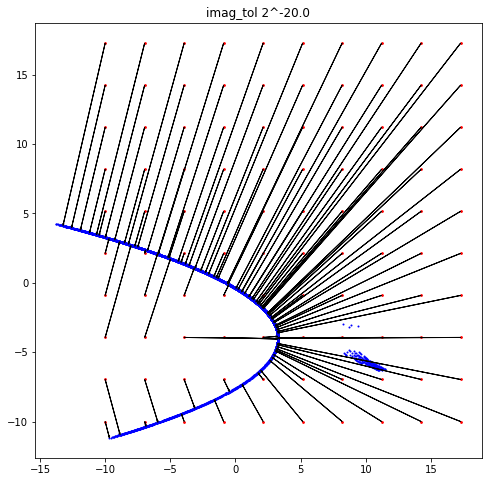

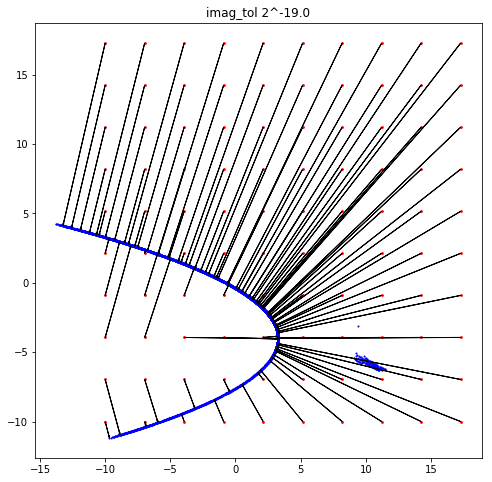

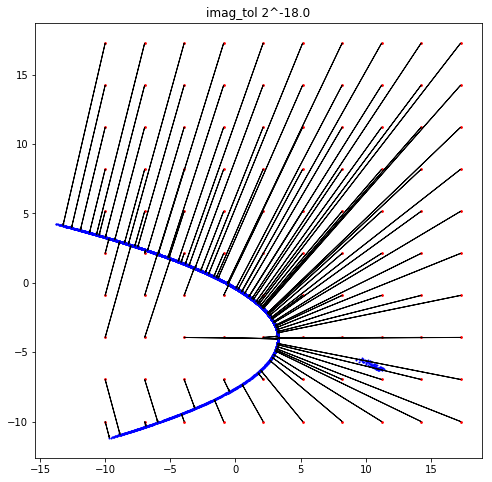

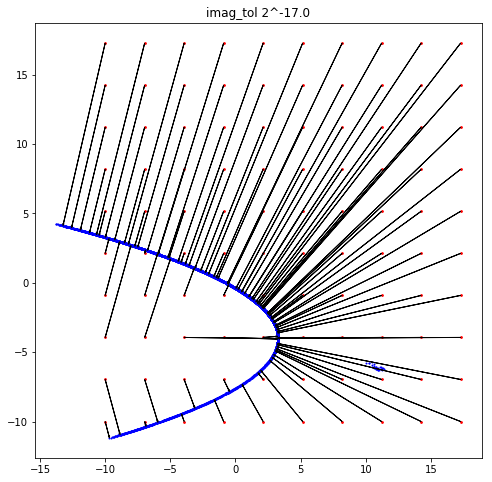

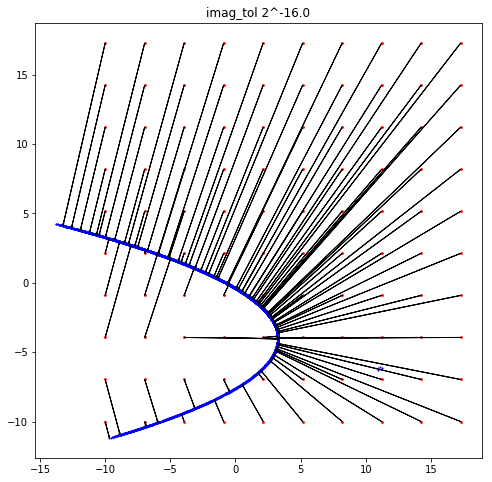

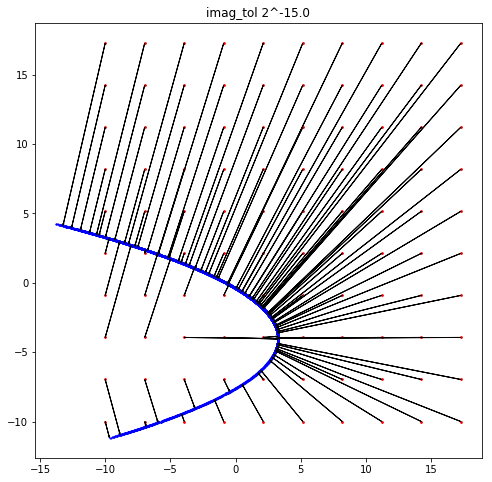

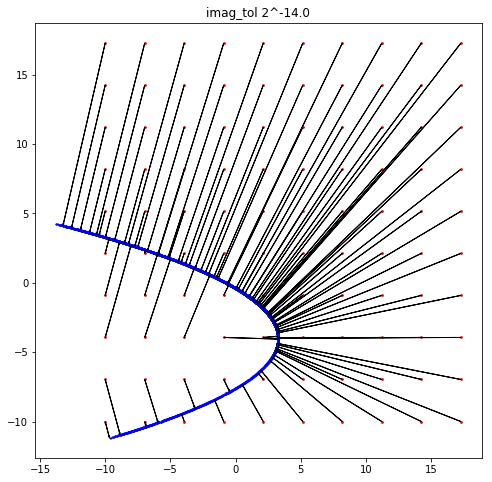

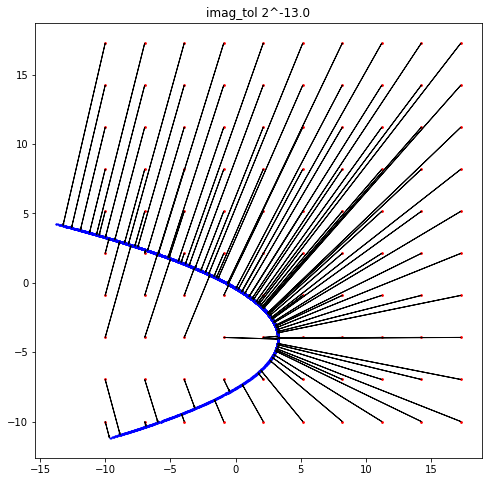

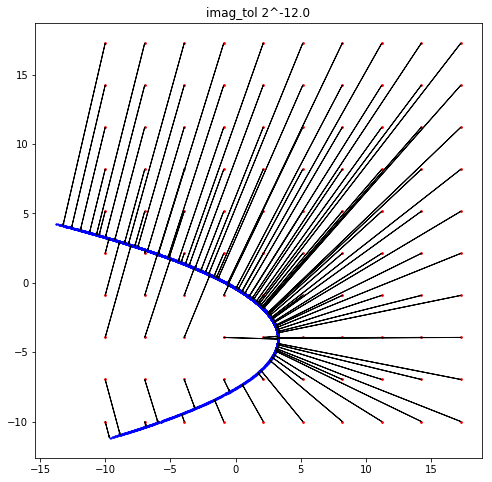

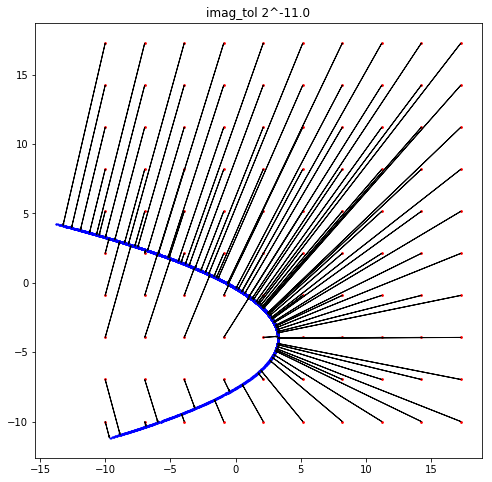

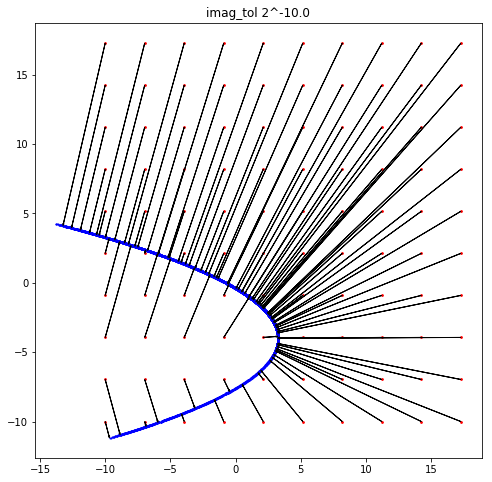

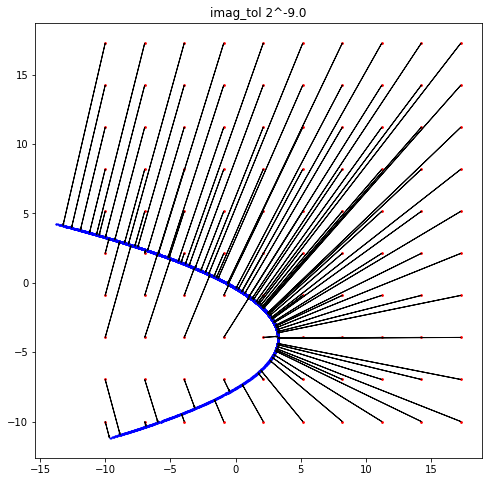

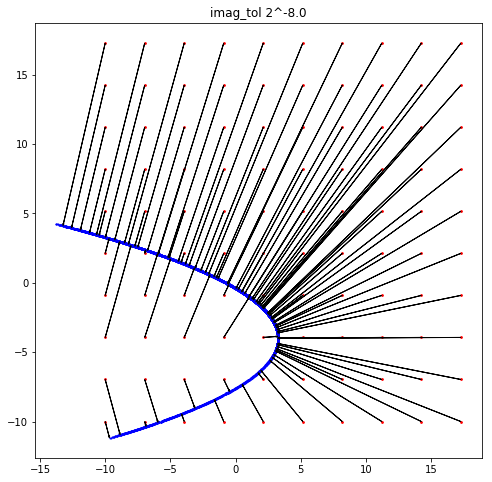

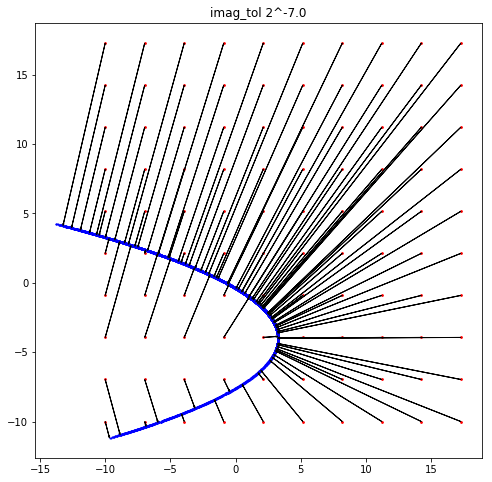

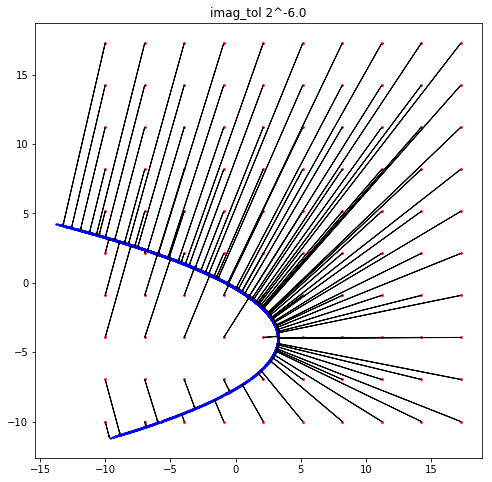

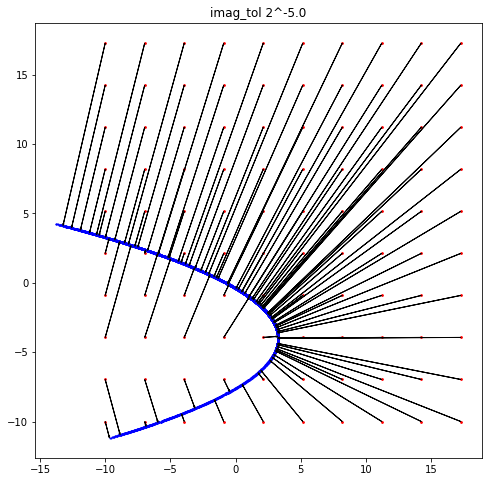

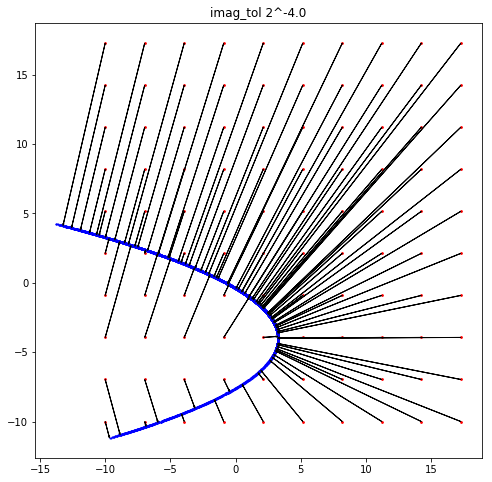

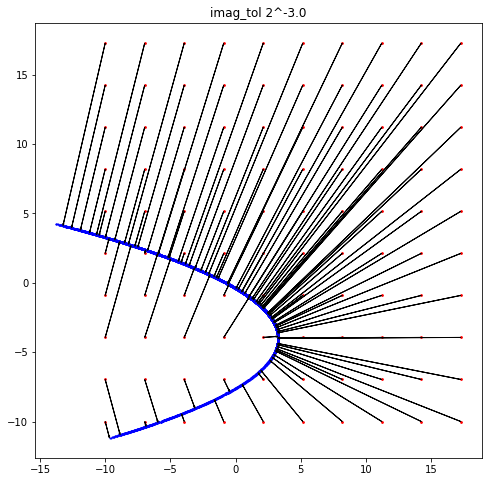

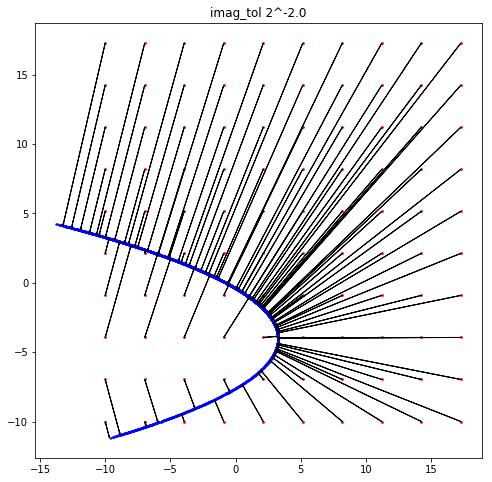

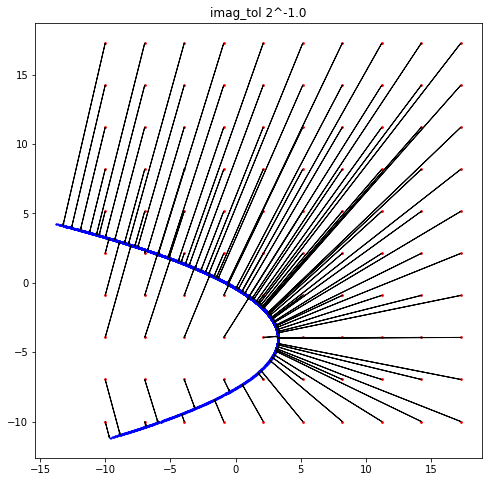

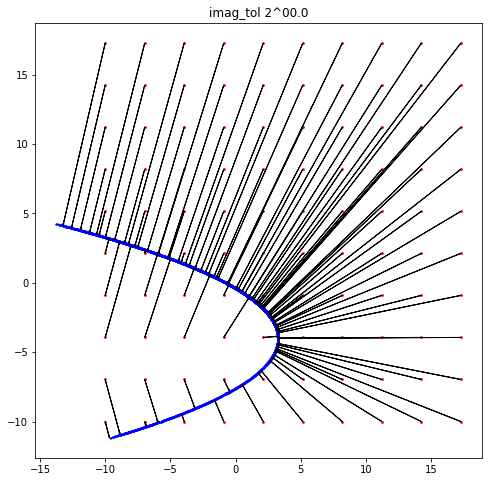

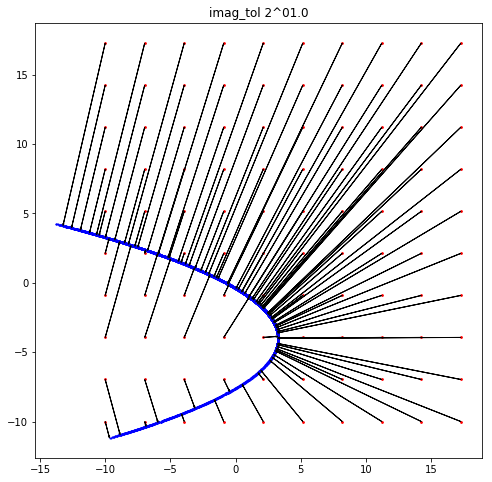

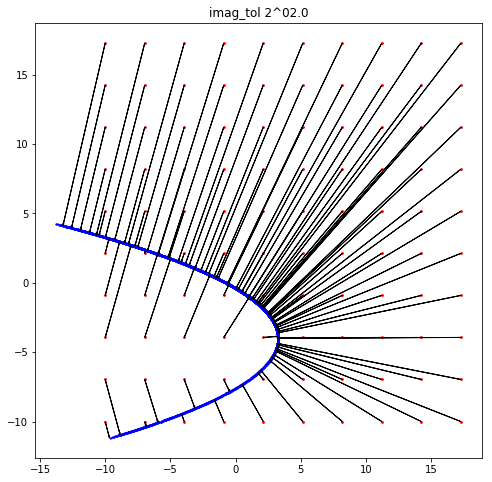

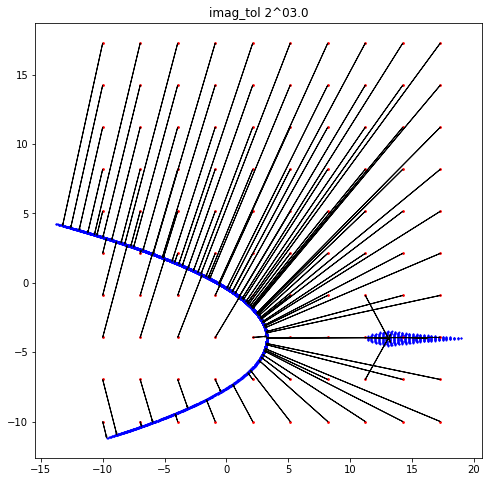

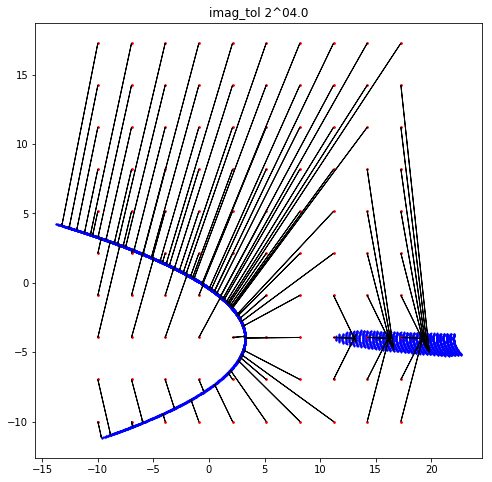

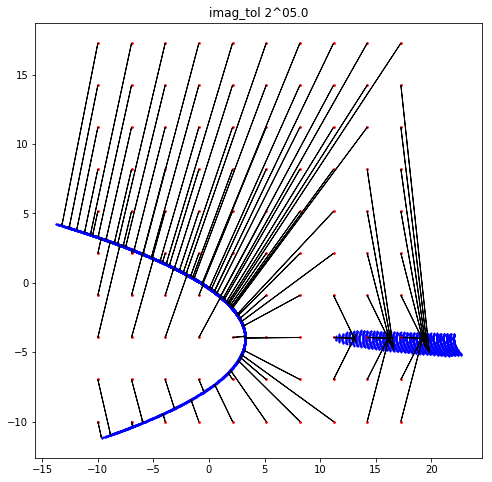

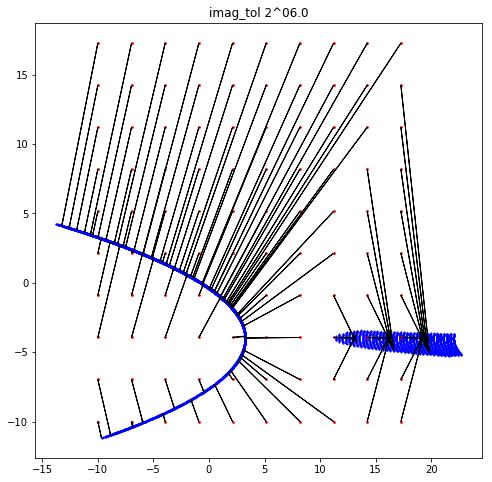

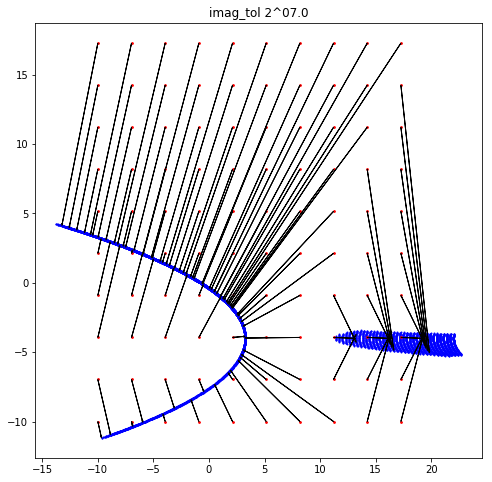

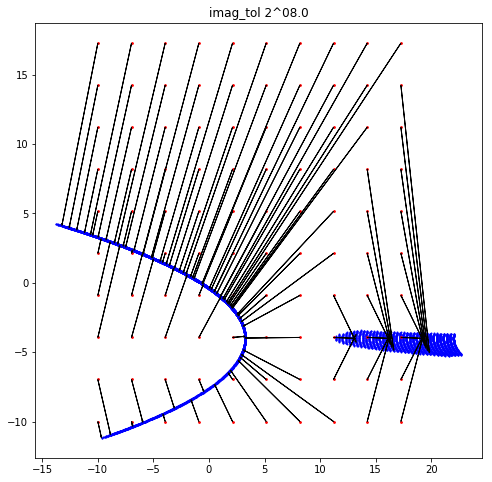

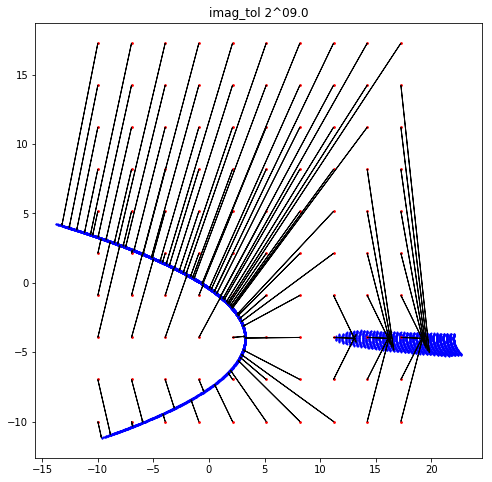

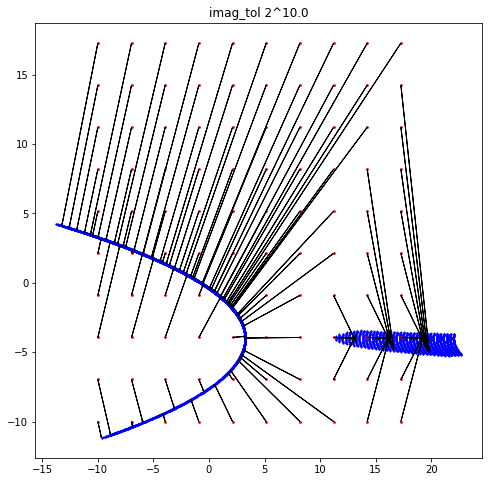

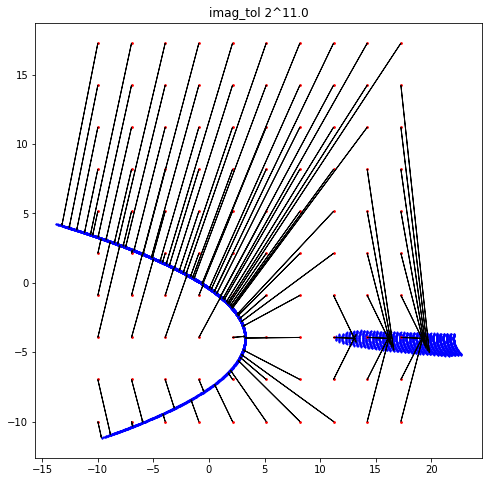

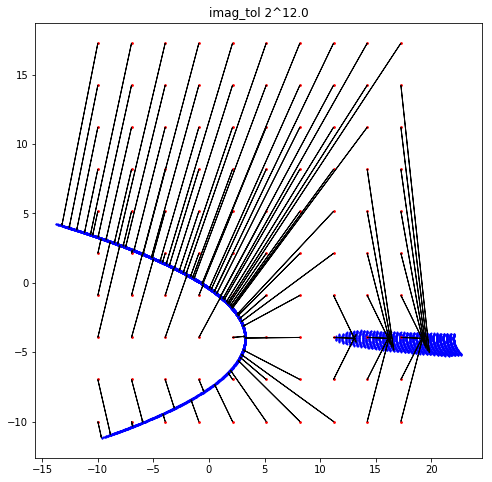

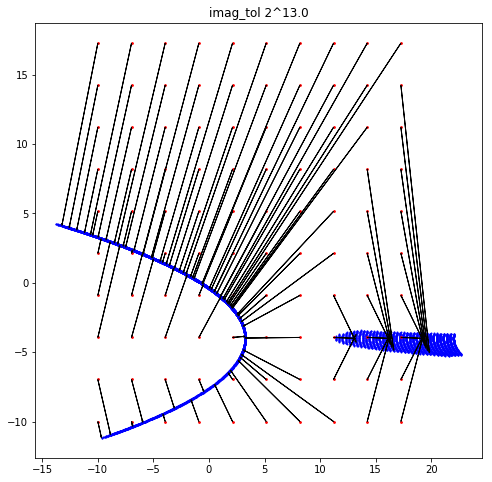

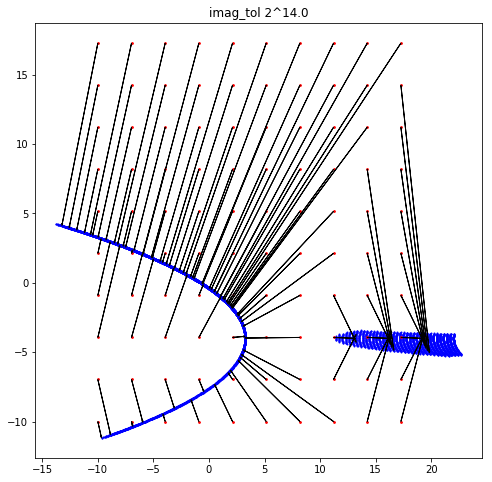

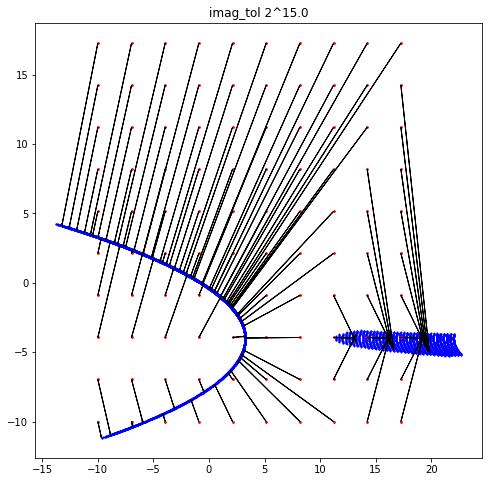

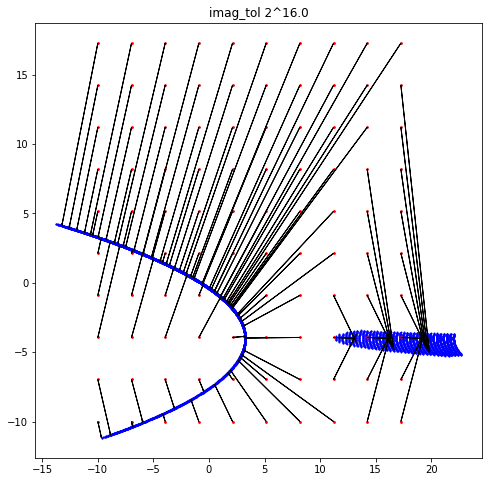

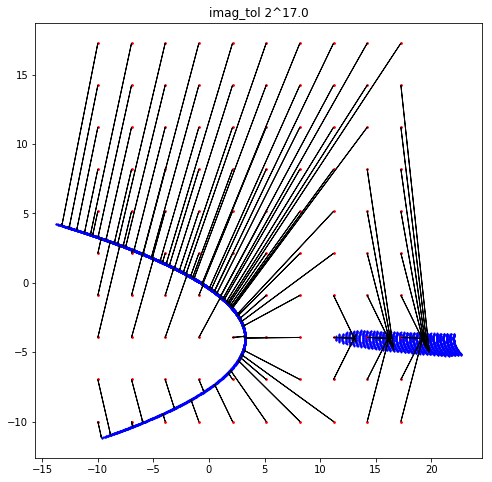

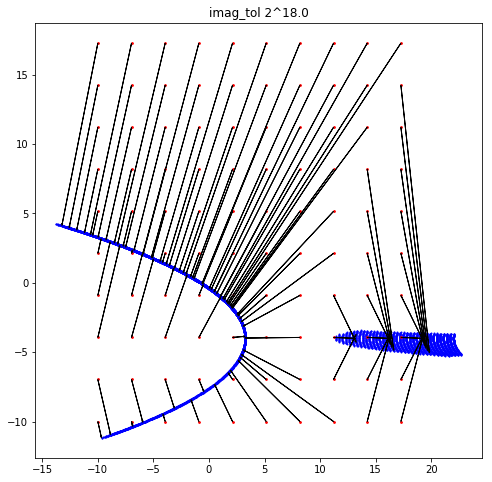

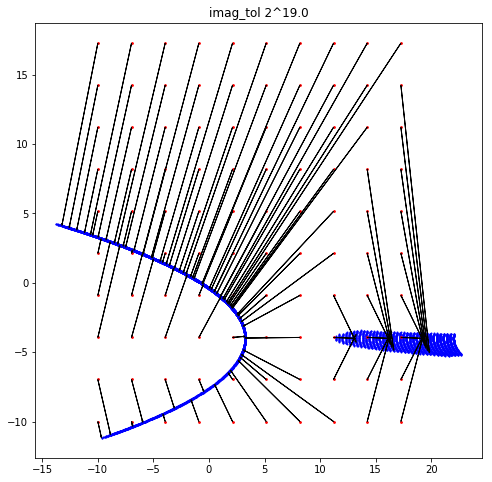

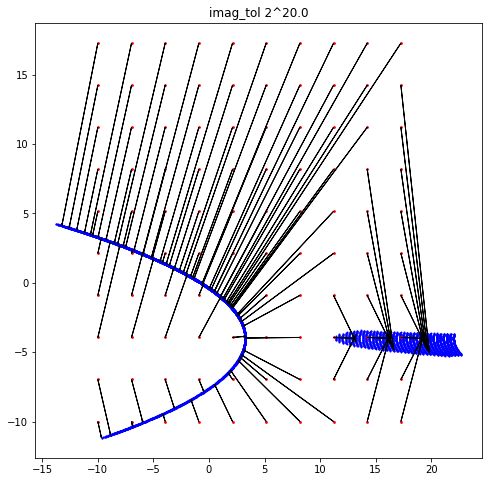

In [34]:
for i, res in enumerate(results):
    res_grid = res[0].reshape(list(xy_grid.shape[1:]) + [2])
    small_res_grid = res_grid[::10,::10]
    small_res = small_res_grid.reshape(-1,2)
    fig = plt.figure()
    plt.scatter(res[0][:,0], res[0][:,1], s=1, c='b')
    plt.scatter(small_xy[:,0], small_xy[:,1], s=3, c='r')
    plt.title("imag_tol 2^{:04.01f}".format(imag_tol_powers[i]))
    for i in range(small_xy.shape[0]):
        plt.arrow(*np.concatenate((small_xy[i],small_res[i]-small_xy[i])),head_width=0.1,fc='g',length_includes_head=True)

In [35]:
parabolic_proj_funcs2d[0]

{'k_mat': <function parabolic_utils_2.k_mat0_2(q_1_1, q_2_2, q_2_0, q_2_1)>,
 'other_dims_as_x': functools.partial(<function munge_other_dims at 0x7f86f9187b70>, 2, 0, other_dims_func=<function other_dims_as_x0_2 at 0x7f86f918cae8>)}

In [36]:
parabola_projected, parabola_dists = local_models.quadric_models.orthogonal_quadric_projection(xy,q_test,projection_funcs)
parabola_projected_small_xy, parabola_dists_small_xy = local_models.quadric_models.orthogonal_quadric_projection(small_xy,q_test,projection_funcs)

[0. 1.] [[1. 0.]
 [0. 1.]]
[0. 1.] [[1. 0.]
 [0. 1.]]


In [37]:
parabola_projected.shape

(10000, 2)

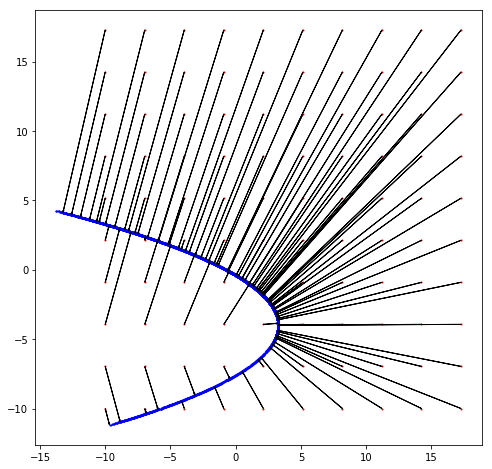

In [38]:
plt.scatter(parabola_projected[:,0], parabola_projected[:,1], s=1, c='b')
plt.scatter(small_xy[:,0], small_xy[:,1], s=1, c='r')
for i in range(small_xy.shape[0]):
    plt.arrow(*np.concatenate((small_xy[i],parabola_projected_small_xy[i]-small_xy[i])),head_width=0.1,fc='g',length_includes_head=True)

In [39]:
q_test

array([[0, 0, 2],
       [0, 1, 4],
       [2, 4, 3]])

In [40]:
import urllib.request
import cv2
bunny_url = "http://3.bp.blogspot.com/-DOPoOpbRsK8/VQO8x9-QmtI/AAAAAAABbR8/ieAZDRsvFMo/s1600/022-how-to-draw-rabbit-easy-steps-4.png"

req = urllib.request.urlopen(bunny_url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'

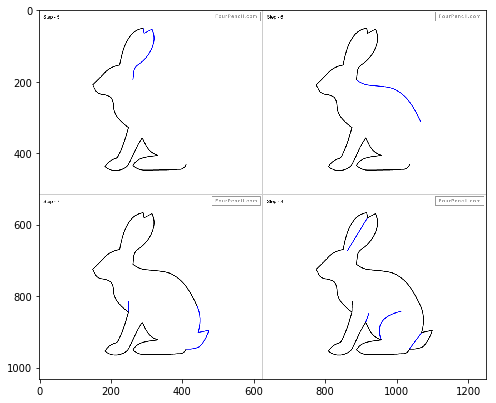

In [41]:
plt.imshow(img)

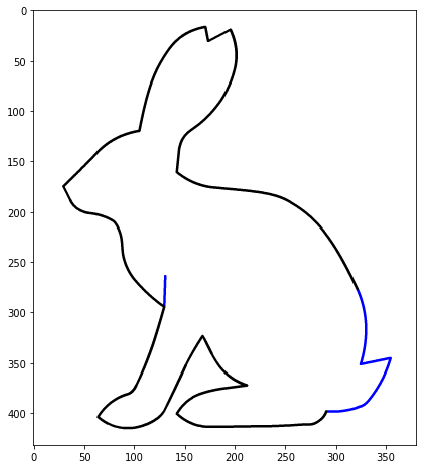

In [42]:
crops = ((550,-50),(120,500))
plt.imshow(img[tuple(itertools.starmap(slice, crops))])

(432, 380)


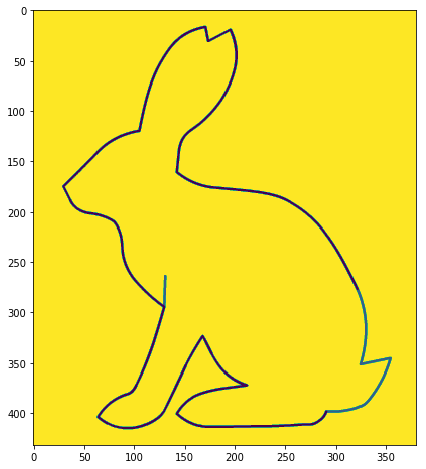

In [43]:
im_gray = cv2.cvtColor(img[tuple(itertools.starmap(slice, crops))], cv2.COLOR_BGR2GRAY)
print(im_gray.shape)
plt.imshow(im_gray)

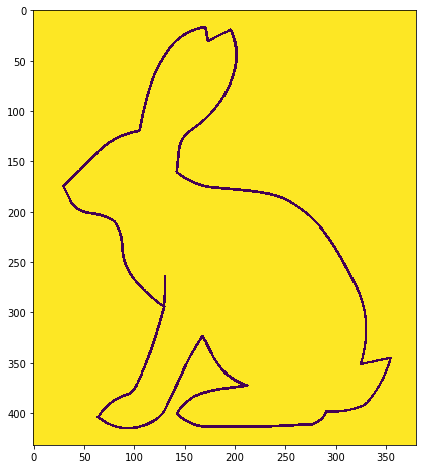

In [44]:
(thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(im_bw)

In [45]:
im_as_ptcloud = np.stack(np.nonzero(im_bw-255), axis=-1)

In [46]:
im_as_ptcloud.shape

(4382, 2)

In [47]:
im_as_ptcloud

array([[ 16, 166],
       [ 16, 167],
       [ 16, 168],
       ...,
       [415, 101],
       [415, 102],
       [415, 103]])

In [48]:
np.random.seed(0)
subsampled_ptcloud = im_as_ptcloud[np.random.choice(im_as_ptcloud.shape[0], 1000, False)]

In [49]:
np.random.seed(0)
very_subsampled_ptcloud = im_as_ptcloud[np.random.choice(im_as_ptcloud.shape[0],100,False)]

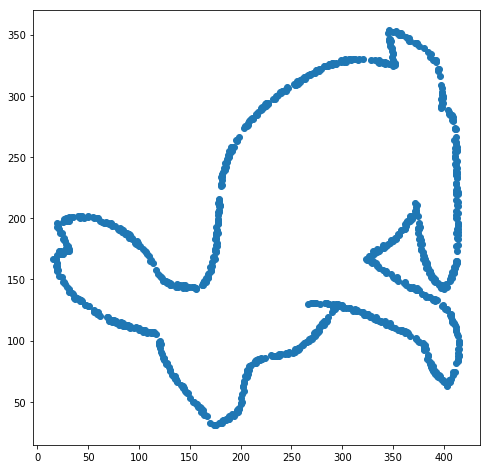

In [50]:
plt.scatter(subsampled_ptcloud[:,0], subsampled_ptcloud[:,1])

In [51]:
parabolic_model = local_models.tf_quadric_models.TFParabolic(n_epochs=300, learning_rate=0.05, trainable=True, batch_size=None, loss_trim=1.,
        log_epochs=True, model=None, weighted=True, input_shape=2, normalize_weights=True,
        projection_funcs = (parabolic_proj_funcs2d[0], parabolic_proj_funcs2d[0]))

building!
Tensor("quadric_regression/quadric_projection/transpose_1:0", shape=(2, 2), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_1:0", shape=(?, 2), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_2:0", shape=(1, 2), dtype=complex128)
L,U,UL,UR,BR Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(2,), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_2:0", shape=(2, 2), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(2,), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_2:0", shape=(?, 2), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_4:0", shape=(?, 1), dtype=complex128)
args0 Tensor("quadric_regression/quadric_projection/cond/strided_slice_2:0", shape=(?, 1), dtype=complex128)
(?, 1)
args1 Tensor("quadric_regression/quadric_projection/cond/strided_slice_3:0", shape=(?, 1), dtype=complex128)
(?, 1)
args2 Tensor("quad

In [52]:
parabolic_model.fit(subsampled_ptcloud, sample_weight=np.ones(subsampled_ptcloud.shape[0]))

TFParabolic(batch_size=None, input_shape=2, learning_rate=0.05, log_epochs=True,
            loss_trim=1.0,
            model=<ml_battery.tensorflow_models.NameSpace object at 0x7f86ac3d7550>,
            n_epochs=300, normalize_weights=True,
            projection_funcs=({'k_mat': <function k_mat0_2 at 0x7f86f918cbf8>,
                               'other_dims_as_x': functools.partial(<function munge_other_dims at 0x7f86f9187b70>, 2, 0, other_dims_func=<function other_dims_as_x0_2 at 0x7f86f918cae8>)},
                              {'k_mat': <function k_mat0_2 at 0x7f86f918cbf8>,
                               'other_dims_as_x': functools.partial(<function munge_other_dims at 0x7f86f9187b70>, 2, 0, other_dims_func=<function other_dims_as_x0_2 at 0x7f86f918cae8>)}),
            trainable=True, weighted=True)

In [53]:
np.tril_indices(3,-1)

(array([1, 2, 2]), array([0, 0, 1]))

In [54]:
fitted_q = np.zeros((3,3))
fitted_q[np.triu_indices(3)] += parabolic_model.coef_
fitted_q[np.tril_indices(3)] += parabolic_model.coef_
fitted_q[np.diag_indices(3)] = fitted_q[np.diag_indices(3)]/2

In [55]:
fitted_q

array([[-0.26950311, -0.26984766, -0.26959991],
       [-0.26984766, -0.26989628, -0.27324108],
       [-0.27019265, -0.27324108,  0.64345854]])

In [56]:
im_grid = np.mgrid[0:400:100j, 0:400:100j]
im_xy = im_grid.T.reshape(-1,2)

In [57]:
res = tf_parabolic_project_2d(im_xy, fitted_q, 1e-4)

Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("add:0", shape=(10000, 2), dtype=complex64) Tensor("add_2:0", shape=(10000, 1), dtype=complex64)
args0 Tensor("cond/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond/mul_9:0", shape=(?, 

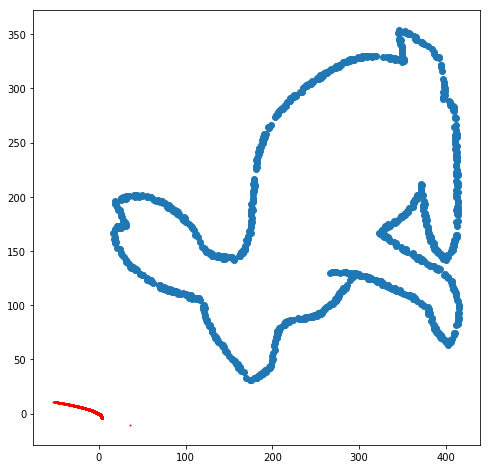

In [58]:
plt.scatter(res[0][:,0], res[0][:,1], s=1, c='r')
plt.scatter(subsampled_ptcloud[:,0], subsampled_ptcloud[:,1])

In [59]:
reasonable_q = parabolic_model.fast_reasonable_q(subsampled_ptcloud, sample_weight=np.ones(subsampled_ptcloud.shape[0]))

In [60]:
res = tf_parabolic_project_2d(im_xy, reasonable_q)

Tensor("transpose:0", shape=(2, 2), dtype=complex64)
Tensor("matmul_1:0", shape=(10000, 2), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 2), dtype=complex64)
L,U,UL,UR,BR Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("GatherV2_2:0", shape=(2, 2), dtype=complex64) Tensor("GatherV2_1:0", shape=(2,), dtype=complex64) Tensor("add:0", shape=(10000, 2), dtype=complex64) Tensor("add_2:0", shape=(10000, 1), dtype=complex64)
args0 Tensor("cond/strided_slice_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
args1 Tensor("cond/strided_slice_3:0", shape=(?, 1), dtype=complex64)
(?, 1)
args2 Tensor("cond/strided_slice_4:0", shape=(?, 1), dtype=complex64)
(?, 1)
args3 Tensor("cond/strided_slice_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses0 Tensor("cond/mul_2:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses1 Tensor("cond/mul_5:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses2 Tensor("cond/mul_8:0", shape=(?, 1), dtype=complex64)
(?, 1)
coeffses3 Tensor("cond/mul_9:0", shape=(?, 

In [61]:
res_grid = res[0].reshape(im_grid.T.shape)
small_res = res_grid[::10,::10].reshape(-1,2)
small_im_xy = im_grid.T[::10,::10].reshape(-1,2)

In [62]:
small_im_xy

array([[  0.        ,   0.        ],
       [ 40.4040404 ,   0.        ],
       [ 80.80808081,   0.        ],
       [121.21212121,   0.        ],
       [161.61616162,   0.        ],
       [202.02020202,   0.        ],
       [242.42424242,   0.        ],
       [282.82828283,   0.        ],
       [323.23232323,   0.        ],
       [363.63636364,   0.        ],
       [  0.        ,  40.4040404 ],
       [ 40.4040404 ,  40.4040404 ],
       [ 80.80808081,  40.4040404 ],
       [121.21212121,  40.4040404 ],
       [161.61616162,  40.4040404 ],
       [202.02020202,  40.4040404 ],
       [242.42424242,  40.4040404 ],
       [282.82828283,  40.4040404 ],
       [323.23232323,  40.4040404 ],
       [363.63636364,  40.4040404 ],
       [  0.        ,  80.80808081],
       [ 40.4040404 ,  80.80808081],
       [ 80.80808081,  80.80808081],
       [121.21212121,  80.80808081],
       [161.61616162,  80.80808081],
       [202.02020202,  80.80808081],
       [242.42424242,  80.80808081],
 

In [63]:
small_res.shape, small_im_xy.shape

((100, 2), (100, 2))

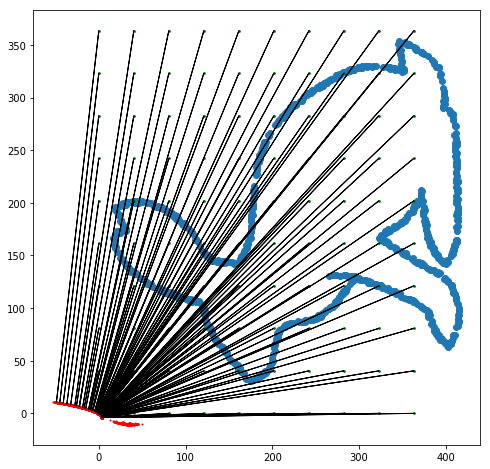

In [64]:
plt.scatter(res[0][:,0], res[0][:,1], s=1, c='r')
plt.scatter(subsampled_ptcloud[:,0], subsampled_ptcloud[:,1])
plt.scatter(small_im_xy[:,0], small_im_xy[:,1], c='g', s=3)
for i in range(small_im_xy.shape[0]):
    plt.arrow(*np.concatenate((small_im_xy[i],small_res[i]-small_im_xy[i])),head_width=0.1,fc='g',length_includes_head=True)